# Squared Exponential kernel Gaussian process - PriorCVAE


This is a demo notebook to showcase the usage of PriorCVAE model on a Gaussian process dataset which is generated using a SquaredExponential kernel.

In [1]:
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)
import jax
import optax
from jax import random
import jax.numpy as jnp

from priorCVAE.models import MLPEncoder, MLPDecoder, VAE
from priorCVAE.priors import GP, SquaredExponential
from priorCVAE.mcmc import run_mcmc_vae, vae_mcmc_inference_model
from priorCVAE.datasets import GPDataset
from priorCVAE.trainer import VAETrainer
from priorCVAE.losses import SquaredSumAndKL

import jax.config as config
config.update("jax_enable_x64", True)

### Configuration

In [2]:
args = {
        "conditional": True,
        
        # architecture
        "input_dim" : 50,
        "hidden_dim": 40,
        "latent_dim": 30,
        
        # VAE training    
        "batch_size": 500,
        "num_iterations": 4000,
        "learning_rate": 1e-3,

        # MCMC inference
        "true_ls": 0.2,
        "num_warmup": 1000,
        "num_samples": 4000,
        "num_chains": 10,
        "thinning": 1,
       }

### Generate data

We generate the data using an SquaredExponential kernel with lengthscale that is uniformly sampled. We plot a sample from the GP and plot the trajectories and lengthscales.

In [3]:
kernel = SquaredExponential()

gp_set = GPDataset(n_data=args["input_dim"], kernel=kernel, sample_lengthscale=True)  

In [4]:
sample_x_train, sample_y_train, sample_ls_train = gp_set.simulatedata(n_samples=1000)
x_test, y_test, ls_test = gp_set.simulatedata(n_samples=1000)

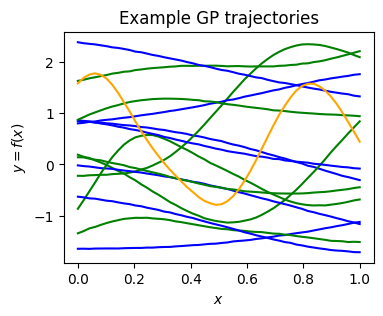

In [5]:
fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    if sample_ls_train[i] <= 0.2:
        col = 'orange'
    elif sample_ls_train[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(sample_x_train[i], sample_y_train[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('Example GP trajectories')

plt.show()

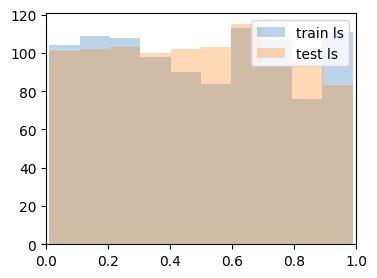

In [6]:
# Plot sample lengthscales
plt.figure(figsize=(4,3))
plt.hist(sample_ls_train[:, 0], alpha = 0.3, label = 'train ls') 
plt.hist(ls_test[:, 0],  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()
plt.show()

### PriorCVAE Model

We define the PriorCVAE model, optimizer, and initialize the parameters of the model randomly.

In [7]:
conditional = args["conditional"]
out_dim     = args["input_dim"]
hidden_dim  = args["hidden_dim"]
latent_dim  = args["latent_dim"]
batch_size  = args["batch_size"]
num_samples = args["num_samples"]
num_iterations  = args["num_iterations"]
true_ls     = args["true_ls"]
learning_rate = args["learning_rate"]

In [8]:
encoder = MLPEncoder(hidden_dim, latent_dim)
decoder = MLPDecoder(hidden_dim, out_dim)
model = VAE(encoder, decoder)

optimizer = optax.adam(learning_rate=learning_rate)
loss = SquaredSumAndKL(conditional=conditional)

### Train the model

Train the model and plot the train loss and the test loss.

In [9]:
trainer = VAETrainer(model, optimizer, loss=loss)
trainer.init_params(sample_y_train[0], c=sample_ls_train[0])

test_set = (x_test, y_test, ls_test)
loss_vals, test_vals, time_taken = trainer.train(gp_set, test_set, num_iterations)

print(f'Training of {num_iterations} iterations took {round(time_taken)} seconds')

[    1] training loss: 6574.402, test loss: 54771.186
[   11] training loss: 3815.312, test loss: 37495.579
[   21] training loss: 3370.737, test loss: 32447.908
[   31] training loss: 3183.973, test loss: 29981.828
[   41] training loss: 2726.683, test loss: 28285.218
[   51] training loss: 2739.368, test loss: 26696.248
[   61] training loss: 2712.891, test loss: 24570.412
[   71] training loss: 2738.929, test loss: 21932.221
[   81] training loss: 1974.843, test loss: 19892.014
[   91] training loss: 1844.224, test loss: 18234.045
[  101] training loss: 1740.202, test loss: 16881.867
[  111] training loss: 1727.444, test loss: 16491.139
[  121] training loss: 1719.646, test loss: 15866.269
[  131] training loss: 1599.391, test loss: 15302.946
[  141] training loss: 1504.919, test loss: 15046.071
[  151] training loss: 1568.705, test loss: 14779.997
[  161] training loss: 1472.871, test loss: 14289.187
[  171] training loss: 1400.604, test loss: 14175.352
[  181] training loss: 1438.

[ 1551] training loss: 821.277, test loss: 7760.881
[ 1561] training loss: 743.903, test loss: 7645.102
[ 1571] training loss: 869.374, test loss: 7761.533
[ 1581] training loss: 736.323, test loss: 7612.739
[ 1591] training loss: 808.261, test loss: 7645.153
[ 1601] training loss: 786.164, test loss: 7619.038
[ 1611] training loss: 809.099, test loss: 7533.732
[ 1621] training loss: 758.165, test loss: 7600.686
[ 1631] training loss: 818.196, test loss: 7643.190
[ 1641] training loss: 786.052, test loss: 7644.305
[ 1651] training loss: 824.517, test loss: 7646.290
[ 1661] training loss: 755.197, test loss: 7613.390
[ 1671] training loss: 707.645, test loss: 7708.604
[ 1681] training loss: 745.941, test loss: 7612.400
[ 1691] training loss: 802.260, test loss: 7617.825
[ 1701] training loss: 835.656, test loss: 7637.565
[ 1711] training loss: 789.656, test loss: 7438.714
[ 1721] training loss: 811.853, test loss: 7573.726
[ 1731] training loss: 837.112, test loss: 7494.208
[ 1741] trai

[ 3131] training loss: 656.962, test loss: 7028.703
[ 3141] training loss: 805.770, test loss: 7013.023
[ 3151] training loss: 644.120, test loss: 6986.672
[ 3161] training loss: 749.387, test loss: 7018.474
[ 3171] training loss: 734.999, test loss: 6926.834
[ 3181] training loss: 694.331, test loss: 6874.438
[ 3191] training loss: 714.317, test loss: 6876.460
[ 3201] training loss: 687.969, test loss: 6978.098
[ 3211] training loss: 697.173, test loss: 6991.772
[ 3221] training loss: 701.214, test loss: 6958.689
[ 3231] training loss: 692.295, test loss: 6998.394
[ 3241] training loss: 608.022, test loss: 6902.847
[ 3251] training loss: 735.334, test loss: 6880.846
[ 3261] training loss: 709.037, test loss: 7020.406
[ 3271] training loss: 797.018, test loss: 7022.296
[ 3281] training loss: 660.904, test loss: 6982.712
[ 3291] training loss: 748.878, test loss: 6948.723
[ 3301] training loss: 670.090, test loss: 7005.082
[ 3311] training loss: 690.630, test loss: 6924.800
[ 3321] trai

Text(0.5, 1.0, 'Test loss')

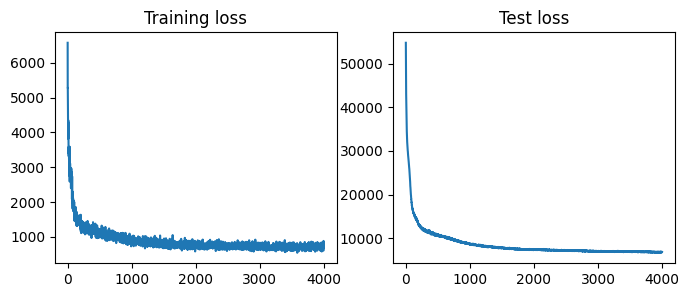

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(range(len(loss_vals)), loss_vals)
axs[0].set_title('Training loss')

axs[1].plot(range(len(test_vals)), test_vals)
axs[1].set_title("Test loss")


### Trained Decoder

We plot a sample of trajectories from the trained decoder model.

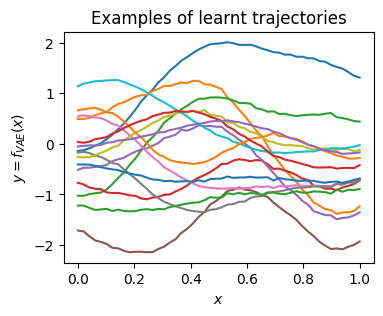

In [11]:
decoder_params = trainer.state.params['decoder']
key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (batch_size, latent_dim))

decoder = MLPDecoder(hidden_dim, out_dim)

c = true_ls * jnp.ones((z.shape[0], 1))
z_c = jnp.concatenate([z, c], axis=-1)
out = decoder.apply({'params': decoder_params}, z_c)             

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(sample_x_train[0], out[i,:])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of learnt trajectories')

plt.show()

### Inference with MCMC

We randomly generate observations from the GP.

#### Generate data

Text(0.5, 1.0, 'Ground truth, corresponds to $ls$=0.2')

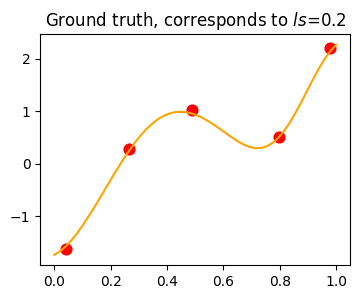

In [12]:
x = sample_x_train[0]

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

kernel = SquaredExponential(lengthscale=true_ls, variance=1.)
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, kernel=kernel, x=x, jitter=1e-6, noise=True)

gp_draw = draws['f'].T
y_draw = draws['y'].T

# choose indices of data points for inference
obs_idx = jnp.array([2, 13, 24, 39, 48])
y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

# add data to args. This is used by MCMC.
args["y_obs"] = y_obs
args["obs_idx"] = obs_idx

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

### Numpyro model

We define a Nupmyro model to run MCMC.

In [13]:
c = true_ls * jnp.ones((1, )) if conditional else None

mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, vae_mcmc_inference_model, args, decoder, 
                                                     decoder_params, c=c)

/Users/vermap1/projects/PriorCVAE_JAX/priorCVAE/mcmc.py:66: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 4. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3373.07it/s, 7 steps of size 3.98e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -1.02      0.31     -1.03     -1.54     -0.51  33570.02      1.00
      f[1]     -1.07      0.34     -1.08     -1.60     -0.49  31984.13      1.00
      f[2]     -1.04      0.34     -1.06     -1.59     -0.48  31958.75      1.00
      f[3]     -1.03      0.34     -1.05     -1.60     -0.49  32188.27      1.00
      f[4]     -0.99      0.32     -1.01     -1.52     -0.46  33161.77      1.00
      f[5]     -0.92      0.31     -0.93     -1.43     -0.41  35037.11      1.00
      f[6]     -0.82      0.29     -0.84     -1.30     -0.34  36934.29      1.00
      f[7]     -0.73      0.28     -0.74     -1.18     -0.28  38739.44      1.00
      f[8]     -0.59      0.26     -0.60     -1.02     -0.16  41155.61      1.00
      f[9]     -0.45      0.24     -0.46     -0.84     -0.05  41800.07      1.00
     f[10]     -0.33      0.24     -0.33     -0.70      0.09  40520.49      1.00
     f[11]     -0.14      0

## Plotting

We plot the trajectory after MCMC.

Text(0.5, 1.0, 'PriorVAE inference')

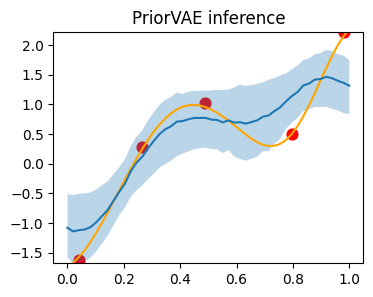

In [14]:
predictive = Predictive(vae_mcmc_inference_model, mcmc_vae_samples)

c = .1 * jnp.ones((1, )) if conditional else None
predictions_vae = predictive(rng_key_preds, args, decoder, decoder_params, c)["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 10

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")
plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, 
                 label="VAE posterior: 90% BCI")

y_min = min(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[0, :]]))
y_max = max(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[1, :]]))

plt.ylim([y_min, y_max])

plt.title('PriorVAE inference')